In [4]:
import math
from copy import deepcopy
import numpy as np
import types
import pylab
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.tools as tls
import sympy
from sympy import *
tls.set_credentials_file(username='Mungos', api_key='mcnflyescl')

In [5]:
class Function():
    def subs_dict(self,x):
        dic = {}
        for i,var in enumerate(self.variables):
            dic[var] = x[i]
        return dic
    
    def gradient_symbolic(self):
        grads = []
        for var in self.variables:
            dif = diff(self.equation,var)
            grads.append(dif)
        return grads
        
    def gradient(self,x):
        self.gradient_calls+=1
        sub_dict = self.subs_dict(x)
        grads = self.gradient_symbolic()
        for i,grad in enumerate(grads):
            grads[i]=grad.evalf(subs=sub_dict)
        return np.array(grads,dtype=np.float32)
        
    def hessean_symbolic(self):
        grads = self.gradient_symbolic()
        hessean = []
        for i,grad in enumerate(grads):
            hess_row = []
            for var in self.variables:
                dif = diff(grad,var)
                hess_row.append(dif)
            hessean.append(hess_row)
        return hessean
        
    def hessean(self,x):
        self.hessean_calls+=1
        hess = self.hessean_symbolic()
        sub_dict = self.subs_dict(x)
        for i,row in enumerate(hess):
            for j, val in enumerate(row):
                hess[i][j] = hess[i][j].evalf(subs=sub_dict)
        return np.array(hess,dtype=np.float32)
        
    def evaluate(self,x, exponential=False):
        self.calls+=1
        subs = self.subs_dict(x)
        value = np.array(self.equation.evalf(subs=subs),dtype=np.float32)
        return value

In [6]:
class Rosenbrock(Function):
    def __init__(self):
        self.calls=0
        self.gradient_calls=0
        self.hessean_calls=0
        self.x1= symbols('x1')
        self.x2 = symbols('x2')
        self.variables = [self.x1,self.x2]
        self.equation = (100*(self.x2-self.x1**2)**2+(1-self.x1)**2)

In [7]:
class F3(Function):
    def __init__(self, num_vars):
        self.calls=0
        self.gradient_calls=0
        self.hessean_calls=0
        self.variables = []
        self.equation = 0
        for i, var in enumerate(range(num_vars)):
            variable = symbols('x'+str(var+1))
            self.variables.append(variable)
            self.equation += (variable-i-1)**2

In [8]:
class F6(Function):
    def __init__(self, num_vars):
        self.calls=0
        self.gradient_calls=0
        self.hessean_calls=0
        self.variables = []
        self.sum_vars = 0
        for i, var in enumerate(range(num_vars)):
            variable = symbols('x'+str(var+1))
            self.variables.append(variable)
            self.sum_vars += (variable)**2
            
        self.equation = 0.5 + ((sin(sqrt(self.sum_vars)))**2-0.5)/(1+0.001*self.sum_vars)

In [9]:
class F7(Function):
    def __init__(self, num_vars):
        self.calls=0
        self.gradient_calls=0
        self.hessean_calls=0
        self.variables = []
        self.sum_vars = 0
        for i, var in enumerate(range(num_vars)):
            variable = symbols('x'+str(var+1))
            self.variables.append(variable)
            self.sum_vars += (variable)**2
            
        self.equation = self.sum_vars**0.25 * (1+(sin(50*self.sum_vars**0.1))**2)

In [97]:
class OperatoriFloat():
    def __init__(self, first_cross=True, mut_chance=0.05):
        self.first_cross = True
        self.mutation_chance = mut_chance
        
    def cross(self, first_parent, second_parent):
        if self.first_cross:
            return self.crossover_1(first_parent, second_parent)
        return self.crossover_2(first_parent, second_parent)
    
    def crossover_1(self, first_parent, second_parent):
        cromosome_length = first_parent.value.shape[0]
        first_parent_copy = first_parent.duplicate()
        for i in range(cromosome_length):
            alpha = np.random.ranf()
            first_parent_copy.value[i] = alpha*first_parent.value[i]+(1-alpha)*second_parent.value[i]
        first_parent_copy.check_boundaries()
        return [first_parent_copy]
        
    def crossover_2(self, first_parent, second_parent):
        cromosome_length = first_parent.value.shape[0]
        if first_parent.fitness < second_parent.fitness:
            better_parent_copy = first_parent.duplicate()
            worst_parent = second_parent
        else:
            better_parent_copy = second_parent.duplicate()
            worst_parent = first_parent
            
        for i in range(cromosome_length):
            alpha = np.random.ranf()
            better_parent_copy.value[i] += alpha*(better_parent_copy.value[i]-worst_parent.value[i])
        first_parent_copy.check_boundaries()
        return [first_parent_copy]
    
    def mutate(self, child):
        cromosome_length = child.value.shape[0]
        for i in range(cromosome_length):
            if np.random.ranf() < self.mutation_chance:
                child.value[i] = np.random.uniform(child.lower_bound,child.upper_bound)
#                 child.value[i] += np.random.normal(0,1,1)
        return child

class OperatoriBinary():
    def __init__(self, first_cross=True,mut_chance=0.05):
        self.first_cross = True
        self.mutation_chance = mut_chance
        
    def cross(self, first_parent, second_parent):
        if self.first_cross:
            return self.crossover_1(first_parent, second_parent)
        return self.crossover_2(first_parent, second_parent)
    
    def crossover_1(self, first_parent, second_parent):
        cross_index = np.random.randint(0,first_parent.value.shape[0])
        cromosome_length = first_parent.value.shape[0]
        first_parent_copy = first_parent.duplicate()
        second_parent_copy = second_parent.duplicate()
        for i in range(cross_index,cromosome_length):
            first_parent_copy.value[i] = second_parent.value[i]
            second_parent_copy.value[i] = first_parent.value[i]
        return [first_parent_copy,second_parent_copy]
        
        
    def crossover_2(self, first_parent, second_parent):
        cross_index = np.random.randint(0,first_parent.value.shape[0])
        second_cross_index = np.random.randint(cross_index,first_parent.value.shape[0])
        cromosome_length = first_parent.value.shape[0]
        first_parent_copy = first_parent.duplicate()
        second_parent_copy = second_parent.duplicate()
        for i in range(cross_index,second_cross_index):
            first_parent_copy.value[i] = second_parent.value[i]
            second_parent_copy.value[i] = first_parent.value[i]
        return [first_parent_copy,second_parent_copy]
    
    def mutate(self, child):
        cromosome_length = child.value.shape[0]
        for i in range(cromosome_length):
            if np.random.ranf() < self.mutation_chance:
                child.value[i] = 1-child.value[i]
        return child

In [11]:
class BinaryUnit():
    def __init__(self, upper_bound, lower_bound, num_vars, precision, value=np.array([])):
        self.fitness = 0
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.num_vars = num_vars
        self.precision = precision
        if value.shape[0]==0:
            self.value = self.init_random()
        else:
            self.value = value
        
    def check_boundaries(self):
        pass
        
    def init_random(self):
        array = []
        for var in range(self.num_vars):
            for prec in range(self.precision):
                array.append(np.random.choice([0,1]))
        return np.array(array)
        
    def evaluate(self, function):
        self.fitness = function.evaluate(self.decode())
        
    def decode(self):
        array = []
        for var in range(self.num_vars):
            val = 0
            start_ind = var*self.precision
            for prec in range(self.precision):
                if self.value[start_ind + prec] == 1:
                    val+=math.pow(2,self.precision-prec-1)
            val = self.lower_bound + (val * 1./(math.pow(2,self.precision)-1))*(self.upper_bound-self.lower_bound)
            array.append(val)
        
        return np.array(array)
    
    def duplicate(self):
        value = self.value.copy()
        return BinaryUnit(self.upper_bound,self.lower_bound,self.num_vars,self.precision,value)
    
    def encode(self):
        pass

class FloatingPointUnit():
    def __init__(self, upper_bound, lower_bound, num_vars, value=np.array([])):
        self.fitness = 0
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.num_vars = num_vars
        if value.shape[0]==0:
            self.value = self.init_random()
        else:
            self.value = value
        
    def init_random(self):
        array = []
        for var in range(self.num_vars):
            array.append(self.lower_bound+(self.upper_bound-self.lower_bound)*np.random.ranf())
        return np.array(array)
    
    def check_boundaries(self):
        for i,value in enumerate(self.value):
            if value > self.upper_bound:
                self.value[i] = self.upper_bound
            if value < self.lower_bound:
                self.value[i] = self.lower_bound
        
    def evaluate(self, function):
        self.fitness = function.evaluate(self.decode())
    
    def decode(self):
        return self.value
    
    
    def duplicate(self):
        value = self.value.copy()
        return FloatingPointUnit(self.upper_bound,self.lower_bound,self.num_vars,value)

In [12]:
class TournamentSelection():
    def __init__(self, num_candidates):
        self.num_candidates = num_candidates
        
    def choose_parent(self, population):
        pop_size = len(population)
        best_found_index = np.random.randint(0,pop_size)
        for i in range(self.num_candidates-1):
            index = np.random.randint(0,pop_size)
            if population[index].fitness < population[best_found_index].fitness:
                best_found_index = index
        return population[best_found_index]

In [35]:
class GeneticAlg():
    
    def __init__(self, pop_size, function, upper_bound, lower_bound, num_vars, precision, number_candidates_tournament, binary_rep = True, first_cross=True, mutation_chance = 0.05, max_evals = 10000, verbose=False, print_last_found = True):
        self.function = function
        self.pop_size = pop_size
        self.num_vars = num_vars
        self.print_last_found = print_last_found
        self.binary_rep = binary_rep
        self.precision = int(math.ceil(math.log(1+(upper_bound-lower_bound)*10**precision)/math.log(2)))
        self.mutation_chance = mutation_chance
        self.max_evals = max_evals
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.tournament = TournamentSelection(number_candidates_tournament)
        self.verbose = verbose
        if binary_rep:
            self.operators = OperatoriBinary(first_cross,mutation_chance)
            self.population = self.init_random_pop(binary_rep)
        else:
            self.operators = OperatoriFloat(first_cross,mutation_chance)
            self.population = self.init_random_pop(binary_rep)
            
        
    def run(self):
        best = None
        key = lambda x: x.fitness
        best_fitness = float('inf')
        best = None
        while self.function.calls < self.max_evals:
            self.population.sort(key = key)
            if best_fitness > self.population[0].fitness:
                best_fitness = self.population[0].fitness
                best = self.population[0]
                if self.verbose:
                    print "######\nBroj evaluacija: %d\nFitness najbolje jedinke: %s\nNajbolja jedinka: %s\nNajbolja jedinka dekodirana: %s\n" % (self.function.calls, best_fitness, str(self.population[0].value), self.population[0].decode())
            self.new_population(elitism=True)
        if self.print_last_found:
            print "######\nBroj evaluacija: %d\nFitness najbolje jedinke: %s\nNajbolja jedinka: %s\nNajbolja jedinka dekodirana: %s\n" % (self.function.calls, best_fitness, str(self.population[0].value), self.population[0].decode())
        return best
    
    def init_random_pop(self, binary_rep = True):
        pop = []
        while len(pop) < self.pop_size:
            if binary_rep:
                unit = BinaryUnit(self.upper_bound,self.lower_bound,self.num_vars,self.precision)
                unit.evaluate(self.function)
                pop.append(unit)
            else:
                unit = FloatingPointUnit(self.upper_bound,self.lower_bound,self.num_vars)
                unit.evaluate(self.function)
                pop.append(unit)
        return pop
    
    def new_population(self, elitism=False):
        new_pop = []
        if elitism:
            new_pop.append(self.population[0])
            if not self.binary_rep:
                self.function.calls+=1 #cisto da mi ne zezne brojanje kasnije da dodem do cistog broja ako koristim float rep
                                       #jer float vraca po 1 dijete blabla...
        while len(new_pop) < self.pop_size:
            par1 = self.tournament.choose_parent(self.population)
            par2 = self.tournament.choose_parent(self.population)
            children = self.operators.cross(par1,par2)
            for child in children:
                child = self.operators.mutate(child)
                child.evaluate(self.function)
                new_pop.append(child)
        self.population = new_pop

# 1. zadatak

### Rosenbrock

In [48]:
lower = -50
upper = 150
prec = 4
num_vars = 2
num_cand = 3
pop = 500
mut = 0.1
fun = Rosenbrock()
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=100000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 100300
Fitness najbolje jedinke: 0.000199493937544
Najbolja jedinka: [0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1
 1 0 1 1 1]
Najbolja jedinka dekodirana: [ 1.00863028  1.01845313]



<__main__.BinaryUnit instance at 0x10ff8e488>

### F3

In [51]:
lower = -50
upper = 150
prec = 4
num_vars = 5
num_cand = 3
pop = 500
mut = 0.05
fun = F3(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=100000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 100300
Fitness najbolje jedinke: 0.158713847399
Najbolja jedinka: [0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0]
Najbolja jedinka dekodirana: [ 1.07824854  1.85434907  3.28390755  4.16557987  4.84717123]



<__main__.BinaryUnit instance at 0x1109dc6c8>

### F6

In [61]:
lower = -50
upper = 150
prec = 4
num_vars = 2
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=100000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 100000
Fitness najbolje jedinke: 2.59904322775e-06
Najbolja jedinka: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0]
Najbolja jedinka dekodirana: [-0.00159741  0.00021458]



<__main__.BinaryUnit instance at 0x1109990e0>

### F7

In [62]:
lower = -50
upper = 150
prec = 4
num_vars = 2
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=100000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 100000
Fitness najbolje jedinke: 0.0313945859671
Najbolja jedinka: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Najbolja jedinka dekodirana: [  9.77516640e-04   2.38418693e-05]



<__main__.BinaryUnit instance at 0x110a1ccb0>

# 2.zad razlicite dimenzionalnosti za F6 i F7

### 1

In [63]:
lower = -50
upper = 150
prec = 4
num_vars = 1
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=100000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 100000
Fitness najbolje jedinke: 5.68718960814e-10
Najbolja jedinka: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Najbolja jedinka dekodirana: [  2.38418693e-05]



<__main__.BinaryUnit instance at 0x10ff7c518>

In [ ]:
lower = -50
upper = 150
prec = 4
num_vars = 1
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=100000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 100000
Fitness najbolje jedinke: 0.00540836993605
Najbolja jedinka: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Najbolja jedinka dekodirana: [  2.38418693e-05]



<__main__.BinaryUnit instance at 0x1109be128>

### 3

In [17]:
lower = -50
upper = 150
prec = 4
num_vars = 3
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.0189810469747
Najbolja jedinka: [0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1
 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1]
Najbolja jedinka dekodirana: [ 4.01251507 -2.4058115   4.19037542]



<__main__.BinaryUnit instance at 0x10a33cc20>

In [19]:
lower = -50
upper = 150
prec = 4
num_vars = 3
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.65239661932
Najbolja jedinka: [0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0]
Najbolja jedinka dekodirana: [-0.35007017  0.03902914 -0.12929446]



<__main__.BinaryUnit instance at 0x10a393d88>

### 6

In [20]:
lower = -50
upper = 150
prec = 4
num_vars = 6
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.193527713418
Najbolja jedinka: [0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0
 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1]
Najbolja jedinka dekodirana: [ -9.75797642   6.76291311   7.90665527 -14.03492166   1.11162716
  15.14943368]



<__main__.BinaryUnit instance at 0x10adbca70>

In [23]:
lower = -50
upper = 150
prec = 4
num_vars = 6
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 3.42043328285
Najbolja jedinka: [0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1]
Najbolja jedinka dekodirana: [ 5.98280715  0.7915739   5.92739865  3.80928698 -6.63163978 -2.04207995]



<__main__.BinaryUnit instance at 0x10a3f0518>

### 10

In [24]:
lower = -50
upper = 150
prec = 4
num_vars = 10
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.359545141459
Najbolja jedinka: [0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0
 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0
 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0]
Najbolja jedinka dekodirana: [ 17.1237312  -33.16611441   3.18396243  24.19007978 -11.36920994
   6.60269575  12.33027569 -14.1726323    2.17402085  -0.10106568]



<__main__.BinaryUnit instance at 0x10ac77488>

In [25]:
lower = -50
upper = 150
prec = 4
num_vars = 10
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 6.76087808609
Najbolja jedinka: [0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1
 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0]
Najbolja jedinka dekodirana: [ -7.71549116 -21.54673173   3.64086802 -15.57396201  26.65675958
  12.51214147 -10.37662524   1.93998906   6.20606242  12.61389857]



<__main__.BinaryUnit instance at 0x10a37a950>

# 3.zad

## 3 varijable

### F6 binarni

In [23]:
lower = -50
upper = 150
prec = 4
num_vars = 3
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.00495047215372
Najbolja jedinka: [0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1]
Najbolja jedinka dekodirana: [-1.73642718  0.27124895 -2.61199599]



<__main__.BinaryUnit instance at 0x10a52a560>

### F6 floating point

In [24]:
lower = -50
upper = 150
prec = 4
num_vars = 3
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut,binary_rep=False)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.0746263191104
Najbolja jedinka: [ 6.81450918  6.11208561  8.474414  ]
Najbolja jedinka dekodirana: [ 6.81450918  6.11208561  8.474414  ]



<__main__.FloatingPointUnit instance at 0x10a52aef0>

### F7 binarni

In [25]:
lower = -50
upper = 150
prec = 4
num_vars = 3
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.60259360075
Najbolja jedinka: [0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1
 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1]
Najbolja jedinka dekodirana: [-0.08771424  0.34573095  0.05867484]



<__main__.BinaryUnit instance at 0x10a540638>

### F7 floating point

In [26]:
lower = -50
upper = 150
prec = 4
num_vars = 3
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut,binary_rep=False)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.248381868005
Najbolja jedinka: [ 0.02203958  0.01154893  0.04955161]
Najbolja jedinka dekodirana: [ 0.02203958  0.01154893  0.04955161]



<__main__.FloatingPointUnit instance at 0x106d95440>

## 6 varijabli

### F6 binarni

In [27]:
lower = -50
upper = 150
prec = 4
num_vars = 6
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.165554121137
Najbolja jedinka: [0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0
 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0]
Najbolja jedinka dekodirana: [ -5.13465649  -2.04980471   2.5131476   15.62827379   9.71158014
 -10.25255215]



<__main__.BinaryUnit instance at 0x10a52b128>

### F6 floating point

In [28]:
lower = -50
upper = 150
prec = 4
num_vars = 6
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut,binary_rep=False)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 0.212690532207
Najbolja jedinka: [ 13.1936495   -7.98489466  15.74172592  11.20706233  -1.04720202
   3.17126455]
Najbolja jedinka dekodirana: [ 13.1936495   -7.98489466  15.74172592  11.20706233  -1.04720202
   3.17126455]



<__main__.FloatingPointUnit instance at 0x10a5b78c0>

### F7 binarni

In [31]:
lower = -50
upper = 150
prec = 4
num_vars = 6
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 3.12480068207
Najbolja jedinka: [0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1
 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0
 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1]
Najbolja jedinka dekodirana: [-3.28061737  4.1335364  -0.05433562  4.45606921 -3.25334227  2.29065527]



<__main__.BinaryUnit instance at 0x10a5b1710>

### F7 floating point

In [30]:
lower = -50
upper = 150
prec = 4
num_vars = 6
num_cand = 3
pop = 500
mut = 0.05
fun = F7(num_vars)
ga = GeneticAlg(500,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut,binary_rep=False)
ga.run()

######
Broj evaluacija: 20000
Fitness najbolje jedinke: 3.41028285027
Najbolja jedinka: [ 3.07007459  5.05858323  5.16115695  2.86657463  5.06670816  6.29717405]
Najbolja jedinka dekodirana: [ 3.07007459  5.05858323  5.16115695  2.86657463  5.06670816  6.29717405]



<__main__.FloatingPointUnit instance at 0x106d9f3f8>

# 4. zadatak

### Test za velicinu populacije

In [38]:
lower = -50
upper = 150
prec = 4
num_vars = 2
num_cand = 3
pop = 500
mut = 0.05
fun = F6(num_vars)
num_trials = 10
results = {}
for pop_size in [30,50,100,200,500]:
    for i in range(num_trials):
        fun = F6(num_vars)
        ga = GeneticAlg(pop_size,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut, print_last_found=False)
        sol = ga.run()
        if pop_size not in results:
            results[pop_size] = [sol]
        else:
            results[pop_size].append(sol)
        print "Done ", i, pop_size

Done  0 30
Done  1 30
Done  2 30
Done  3 30
Done  4 30
Done  5 30
Done  6 30
Done  7 30
Done  8 30
Done  9 30
Done  0 50
Done  1 50
Done  2 50
Done  3 50
Done  4 50
Done  5 50
Done  6 50
Done  7 50
Done  8 50
Done  9 50
Done  0 100
Done  1 100
Done  2 100
Done  3 100
Done  4 100
Done  5 100
Done  6 100
Done  7 100
Done  8 100
Done  9 100
Done  0 200
Done  1 200
Done  2 200
Done  3 200
Done  4 200
Done  5 200
Done  6 200
Done  7 200
Done  8 200
Done  9 200
Done  0 500
Done  1 500
Done  2 500
Done  3 500
Done  4 500
Done  5 500
Done  6 500
Done  7 500
Done  8 500
Done  9 500


In [72]:
sort_key = lambda x: x.fitness
for key in sorted(results.keys()):
    print "##### %s #####" % (key)
    results[key].sort(key = sort_key)
    for sol in results[key]:
        print sol.fitness, key

##### 30 #####
5.68718938609e-09 30
5.68718938609e-09 30
0.00488417921588 30
0.00488417921588 30
0.00488417921588 30
0.00488417921588 30
0.00488417921588 30
0.00488417921588 30
0.00488417921588 30
0.00488417968154 30
##### 50 #####
5.68718938609e-09 50
5.68718938609e-09 50
1.02369410726e-08 50
0.00488417921588 50
0.00488417921588 50
0.00488417921588 50
0.00488417921588 50
0.00488417921588 50
0.00488417921588 50
0.00488417968154 50
##### 100 #####
5.68718938609e-09 100
0.00488417921588 100
0.00488417921588 100
0.00488417921588 100
0.00488417921588 100
0.00488417921588 100
0.00488417921588 100
0.00488417921588 100
0.00488417921588 100
0.00488417968154 100
##### 200 #####
1.72094257778e-06 200
0.000171430510818 200
0.00488417921588 200
0.00488417921588 200
0.00488417921588 200
0.00488417968154 200
0.0048841801472 200
0.00488418061286 200
0.00488418061286 200
0.00488418107852 200
##### 500 #####
2.39690361923e-05 500
0.000205189964618 500
0.000703795929439 500
0.00302164885215 500
0.003258

Mean za velicinu populacije 30 iznosi 0.00488417921588
Mean za velicinu populacije 50 iznosi 0.00488417921588
Mean za velicinu populacije 100 iznosi 0.00488417921588
Mean za velicinu populacije 200 iznosi 0.00488417968154
Mean za velicinu populacije 500 iznosi 0.0048841801472


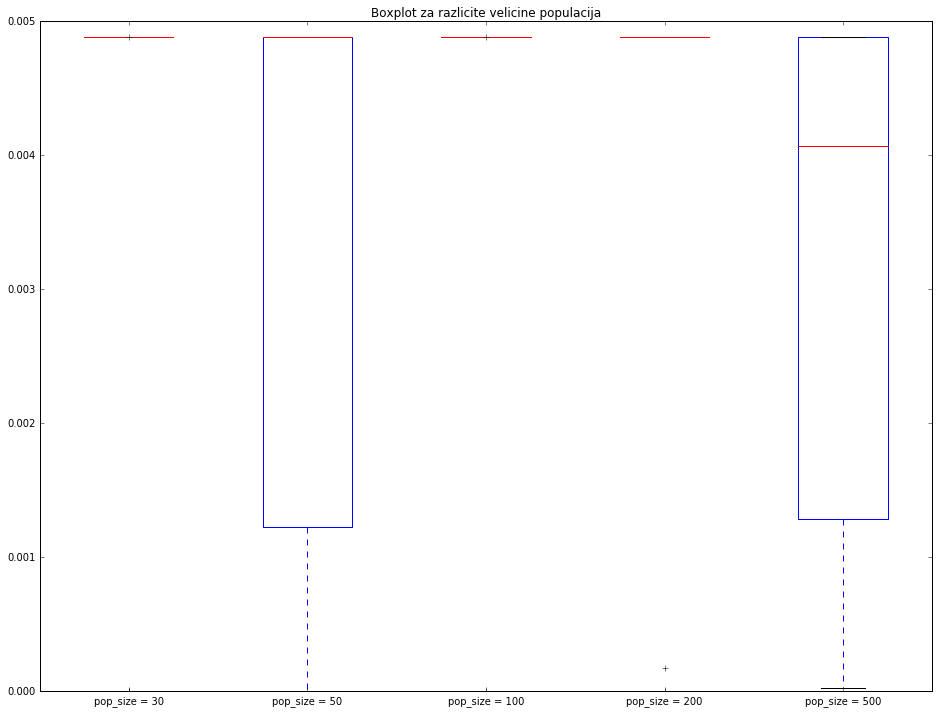

In [70]:
data_to_plot = []
for key in sorted(results.keys()):
    values = []
    mean = 0
    for val in results[key]:
        values.append(val.fitness)
    if len(results[key]) %2 == 0:
        first_cand = results[key][len(results[key])/2]
        second_cand = results[key][len(results[key])/2+1]
        mean = (first_cand.fitness+second_cand.fitness)/2.
    else:
        mean = results[key][len(results[key])/2].fitness
    print "Mean za velicinu populacije %s iznosi %s" % (key, mean)
    data_to_plot.append(np.array(values))
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
plt.title("Boxplot za razlicite velicine populacija")
plt.xticks([1, 2, 3, 4, 5], ['pop_size = 30', 'pop_size = 50', 'pop_size = 100','pop_size = 200','pop_size = 500'])
plt.show()

# 5.zadatak

### Test za razlicite velicine turnirske selekcije

In [82]:
lower = -50
upper = 150
prec = 4
num_vars = 2
pop = 50
mut = 0.05
fun = F6(num_vars)
num_trials = 10
tournament_results = {}
for num_cand in [2,4,6,8,10]:
    for i in range(num_trials):
        fun = F6(num_vars)
        ga = GeneticAlg(pop,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut, print_last_found=False)
        sol = ga.run()
        if num_cand not in tournament_results:
            tournament_results[num_cand] = [sol]
        else:
            tournament_results[num_cand].append(sol)
        print "Done ", i, num_cand

Done  0 2
Done  1 2
Done  2 2
Done  3 2
Done  4 2
Done  5 2
Done  6 2
Done  7 2
Done  8 2
Done  9 2
Done  0 4
Done  1 4
Done  2 4
Done  3 4
Done  4 4
Done  5 4
Done  6 4
Done  7 4
Done  8 4
Done  9 4
Done  0 6
Done  1 6
Done  2 6
Done  3 6
Done  4 6
Done  5 6
Done  6 6
Done  7 6
Done  8 6
Done  9 6
Done  0 8
Done  1 8
Done  2 8
Done  3 8
Done  4 8
Done  5 8
Done  6 8
Done  7 8
Done  8 8
Done  9 8
Done  0 10
Done  1 10
Done  2 10
Done  3 10
Done  4 10
Done  5 10
Done  6 10
Done  7 10
Done  8 10
Done  9 10


In [85]:
sort_key = lambda x: x.fitness
for key in sorted(tournament_results.keys()):
    print "##### %s #####" % (key)
    tournament_results[key].sort(key = sort_key)
    for sol in tournament_results[key]:
        print sol.fitness, key

##### 2 #####
5.68718938609e-09 2
2.05876247605e-07 2
2.10425994851e-07 2
3.03126898871e-06 2
3.92831789213e-05 2
0.00488417921588 2
0.00488417921588 2
0.00488417921588 2
0.00488417921588 2
0.00488418200985 2
##### 4 #####
5.68718938609e-09 4
5.68718938609e-09 4
1.02369410726e-08 4
1.02369410726e-08 4
0.00488417921588 4
0.00488417921588 4
0.00488417921588 4
0.00488417921588 4
0.00488417921588 4
0.00488417921588 4
##### 6 #####
1.13743792163e-09 6
5.68718938609e-09 6
5.68718938609e-09 6
0.00488417921588 6
0.00488417921588 6
0.00488417921588 6
0.00488417921588 6
0.00488417921588 6
0.00488417921588 6
0.00488417921588 6
##### 8 #####
1.13743792163e-09 8
5.68718938609e-09 8
1.02369410726e-08 8
1.02369410726e-08 8
0.00488417921588 8
0.00488417921588 8
0.00488417921588 8
0.00488417921588 8
0.00488417921588 8
0.00488417921588 8
##### 10 #####
1.13743792163e-09 10
5.68718938609e-09 10
5.68718938609e-09 10
1.02369410726e-08 10
1.02369410726e-08 10
0.00488417921588 10
0.00488417921588 10
0.004884

Mean za velicinu populacije 2 iznosi 0.00488417921588
Mean za velicinu populacije 4 iznosi 0.00488417921588
Mean za velicinu populacije 6 iznosi 0.00488417921588
Mean za velicinu populacije 8 iznosi 0.00488417921588
Mean za velicinu populacije 10 iznosi 0.00488417921588


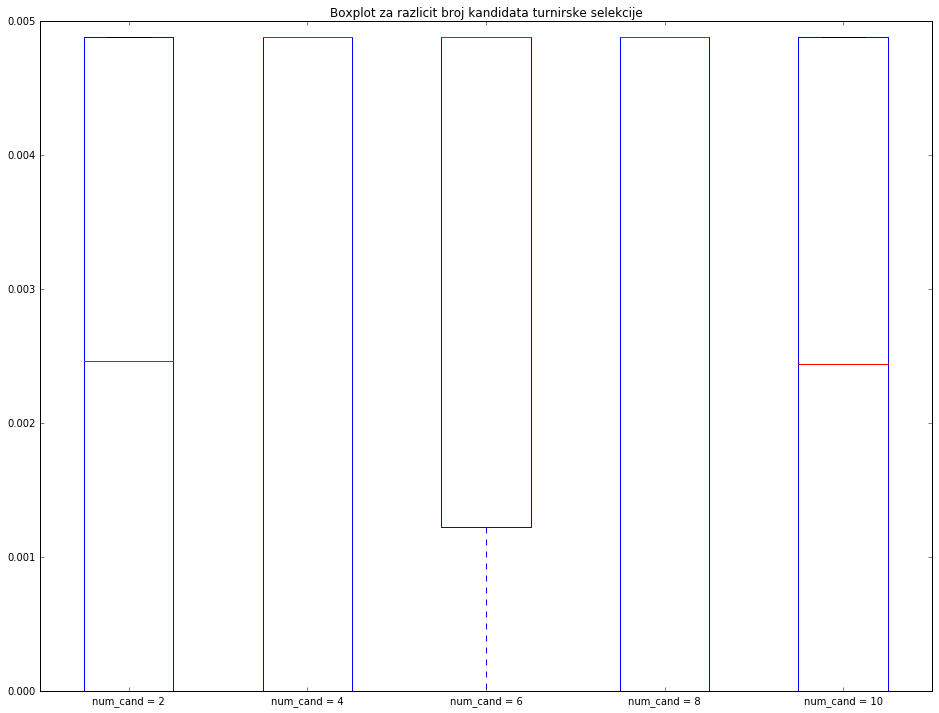

In [96]:
data_to_plot = []
for key in sorted(tournament_results.keys()):
    values = []
    mean = 0
    for val in tournament_results[key]:
        values.append(val.fitness)
    if len(tournament_results[key]) %2 == 0:
        first_cand = tournament_results[key][len(tournament_results[key])/2]
        second_cand = tournament_results[key][len(tournament_results[key])/2+1]
        mean = (first_cand.fitness+second_cand.fitness)/2.
    else:
        mean = tournament_results[key][len(tournament_results[key])/2].fitness
    print "Mean za velicinu populacije %s iznosi %s" % (key, mean)
    data_to_plot.append(np.array(values))
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
plt.title("Boxplot za razlicit broj kandidata turnirske selekcije")
plt.xticks([1, 2, 3, 4, 5], ['num_cand = 2','num_cand = 4','num_cand = 6','num_cand = 8','num_cand = 10'])
plt.show()

### Test za razlicite mutacija

In [90]:
lower = -50
upper = 150
prec = 4
num_vars = 2
pop = 50
num_cand = 10
fun = F6(num_vars)
num_trials = 10
mutation_results = {}
for mut in [0.1,0.3,0.6,0.9]:
    for i in range(num_trials):
        fun = F6(num_vars)
        ga = GeneticAlg(pop,fun,upper,lower,num_vars,prec,num_cand,max_evals=20000,mutation_chance=mut, print_last_found=False)
        sol = ga.run()
        if mut not in mutation_results:
            mutation_results[mut] = [sol]
        else:
            mutation_results[mut].append(sol)
        print "Done ", i, mut

Done  0 0.1
Done  1 0.1
Done  2 0.1
Done  3 0.1
Done  4 0.1
Done  5 0.1
Done  6 0.1
Done  7 0.1
Done  8 0.1
Done  9 0.1
Done  0 0.3
Done  1 0.3
Done  2 0.3
Done  3 0.3
Done  4 0.3
Done  5 0.3
Done  6 0.3
Done  7 0.3
Done  8 0.3
Done  9 0.3
Done  0 0.6
Done  1 0.6
Done  2 0.6
Done  3 0.6
Done  4 0.6
Done  5 0.6
Done  6 0.6
Done  7 0.6
Done  8 0.6
Done  9 0.6
Done  0 0.9
Done  1 0.9
Done  2 0.9
Done  3 0.9
Done  4 0.9
Done  5 0.9
Done  6 0.9
Done  7 0.9
Done  8 0.9
Done  9 0.9


In [91]:
sort_key = lambda x: x.fitness
for key in sorted(mutation_results.keys()):
    print "##### %s #####" % (key)
    mutation_results[key].sort(key = sort_key)
    for sol in mutation_results[key]:
        print sol.fitness, key

##### 0.1 #####
4.66349519002e-08 0.1
6.93837094445e-08 0.1
0.00488417921588 0.1
0.00488417921588 0.1
0.00488417921588 0.1
0.00488417921588 0.1
0.00488417921588 0.1
0.00488417921588 0.1
0.00488417968154 0.1
0.00488418061286 0.1
##### 0.3 #####
0.00488976994529 0.3
0.00489078415558 0.3
0.00492150662467 0.3
0.00496159028262 0.3
0.00499590486288 0.3
0.00500037940219 0.3
0.00500365206972 0.3
0.00526271760464 0.3
0.00531019503251 0.3
0.00552361551672 0.3
##### 0.6 #####
0.00491084018722 0.6
0.00493293767795 0.6
0.00494569446892 0.6
0.00497906561941 0.6
0.00507744960487 0.6
0.00527213746682 0.6
0.0053188004531 0.6
0.00538248475641 0.6
0.0106301754713 0.6
0.0190663728863 0.6
##### 0.9 #####
0.00488426955417 0.9
0.00488675385714 0.9
0.00489502679557 0.9
0.00490611046553 0.9
0.00492783915251 0.9
0.00496829347685 0.9
0.00501039857045 0.9
0.00549465650693 0.9
0.0056246551685 0.9
0.00591897824779 0.9


Mean za velicinu populacije 0.1 iznosi 0.00488417921588
Mean za velicinu populacije 0.3 iznosi 0.00500201573595
Mean za velicinu populacije 0.6 iznosi 0.00529546895996
Mean za velicinu populacije 0.9 iznosi 0.00498934602365


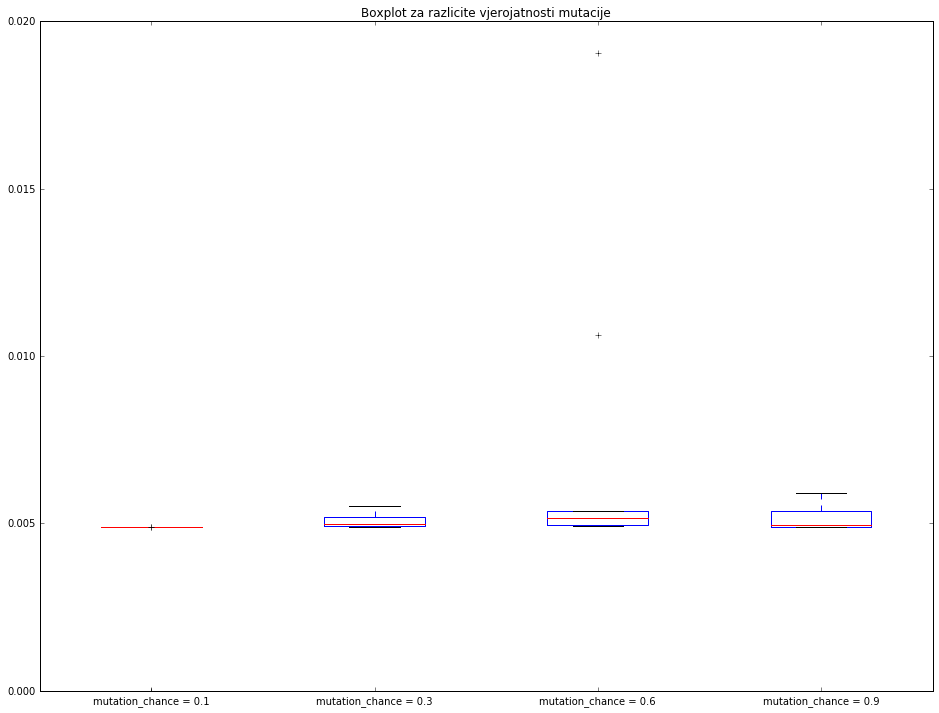

In [95]:
data_to_plot = []
for key in sorted(mutation_results.keys()):
    values = []
    mean = 0
    for val in mutation_results[key]:
        values.append(val.fitness)
    if len(mutation_results[key]) %2 == 0:
        first_cand = mutation_results[key][len(mutation_results[key])/2]
        second_cand = mutation_results[key][len(mutation_results[key])/2+1]
        mean = (first_cand.fitness+second_cand.fitness)/2.
    else:
        mean = mutation_results[key][len(mutation_results[key])/2].fitness
    print "Mean za velicinu populacije %s iznosi %s" % (key, mean)
    data_to_plot.append(np.array(values))
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
plt.title("Boxplot za razlicite vjerojatnosti mutacije")
plt.xticks([1, 2, 3, 4], ['mutation_chance = 0.1','mutation_chance = 0.3','mutation_chance = 0.6','mutation_chance = 0.9'])
plt.show()